In [1]:
import os
import requests
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS # vector store
from langchain_openai import ChatOpenAI,OpenAIEmbeddings # tend to use this whenever gemini runs into quota limit
from langchain_google_vertexai import ChatVertexAI # runs into quota limit sometimes
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import Optional, Type
from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import WebBaseLoader # web document loader
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langgraph.checkpoint import MemorySaver  # an in-memory checkpointer
from langgraph.prebuilt import create_react_agent
load_dotenv()

True

In [2]:
# For tracing and debugging
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# credential.json is not required if you are working within your own GCP project's vertex AI workbench
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/Transcendent/fleet-anagram-244304-7dafcc771b2f.json"

# if you are using text embedding model from google
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

GITHUB_ACCESS_TOKEN = os.getenv("GITHUB_ACCESS_TOKEN")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Plan-and-execute"

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=5)]

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o")
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


In [5]:
response = agent_executor.invoke({"messages": [("user", "What are the popular destinations in Hokkaido, assuming we are going in summer? Create a list for both sightseeing and food and construct a dataset in geopandas format")]})

In [6]:

from IPython.display import display, Markdown

# assuming response is defined and structured as expected
display(Markdown(response["messages"][-1].content))

Based on the search results, here is a list of popular sightseeing and food destinations in Hokkaido for the summer:

### Sightseeing Destinations:
1. **Sapporo**:
   - Capital city of Hokkaido, known for its vibrant city life, beer, and the annual Sapporo Summer Festival.
2. **Asahikawa**:
   - Famous for Asahiyama Zoo and its beautiful flower fields.
3. **Biei**:
   - Renowned for its picturesque rural landscapes and flower fields.
4. **Furano**:
   - Known for its lavender fields and vibrant flower gardens.
5. **Hakodate**:
   - Features historical sites like Fort Goryokaku and offers stunning night views from Mount Hakodate.
6. **Daisetsuzan National Park**:
   - Largest national park in Japan, great for hiking and experiencing natural hot springs.
7. **Lake Toya**:
   - A scenic caldera lake with hot spring resorts.
8. **Noboribetsu**:
   - Famous for its hot springs and Jigokudani (Hell Valley).
9. **Otaru**:
   - A port city known for its well-preserved canal area and glassworks.
10. **Shakotan Peninsula**:
    - Known for its rugged coastline and underwater marine park.

### Food Destinations:
1. **Sapporo**:
   - Known for Sapporo Beer Festival and a variety of seafood.
2. **Shakotan Peninsula**:
   - Best sea urchin bowls (uni).
3. **Furano**:
   - Lavender ice cream.
4. **Hakodate**:
   - Morning markets with fresh seafood.
5. **Otaru**:
   - Fresh sushi and seafood.
6. **Kombu (kelp)**:
   - Available throughout Hokkaido, particularly known varieties are Makombu, Rishiri Kombu, Hidaka Kombu, and Rausu Kombu.
7. **Crab**:
   - Specialty crab dinners available in many restaurants.
8. **Soft serve ice cream**:
   - Available throughout Hokkaido, especially in dairy-rich areas.
9. **Sapporo**:
   - Dairy products and farm fresh ingredients.

### Geopandas Dataset:
To create a geopandas dataset, we can construct a DataFrame with columns for the name of the destination, type (sightseeing/food), and coordinates (latitude and longitude). Here's an example:

```python
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

data = {
    'Name': ['Sapporo', 'Asahikawa', 'Biei', 'Furano', 'Hakodate', 'Daisetsuzan National Park', 'Lake Toya', 'Noboribetsu', 'Otaru', 'Shakotan Peninsula'],
    'Type': ['Sightseeing', 'Sightseeing', 'Sightseeing', 'Sightseeing', 'Sightseeing', 'Sightseeing', 'Sightseeing', 'Sightseeing', 'Sightseeing', 'Sightseeing'],
    'Latitude': [43.06, 43.77, 43.59, 43.34, 41.77, 43.66, 42.56, 42.41, 43.19, 43.23],
    'Longitude': [141.35, 142.37, 142.46, 142.38, 140.73, 142.87, 140.83, 141.13, 141.00, 140.52]
}
sightseeing_df = pd.DataFrame(data)
sightseeing_df['Coordinates'] = sightseeing_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
sightseeing_gdf = gpd.GeoDataFrame(sightseeing_df, geometry='Coordinates')

food_data = {
    'Name': ['Sapporo', 'Shakotan Peninsula', 'Furano', 'Hakodate', 'Otaru', 'Kombu', 'Crab', 'Soft serve ice cream', 'Sapporo'],
    'Type': ['Food', 'Food', 'Food', 'Food', 'Food', 'Food', 'Food', 'Food', 'Food'],
    'Latitude': [43.06, 43.23, 43.34, 41.77, 43.19, 43.06, 43.06, 43.06, 43.06],
    'Longitude': [141.35, 140.52, 142.38, 140.73, 141.00, 141.35, 141.35, 141.35, 141.35]
}
food_df = pd.DataFrame(food_data)
food_df['Coordinates'] = food_df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
food_gdf = gpd.GeoDataFrame(food_df, geometry='Coordinates')

# Combine both GeoDataFrames
hokkaido_gdf = pd.concat([sightseeing_gdf, food_gdf], ignore_index=True)
```

This dataset can be further enriched with more detailed information and coordinates for precise locations.

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [8]:
response = agent_executor.invoke({"messages": [("user","Can you create a geopandas dataset for the popular destinations in Hokkaido and create a map for it using folium?")]})

In [9]:
display(Markdown(response["messages"][-1].content))

Here are some popular destinations in Hokkaido:

1. **Shirogane Blue Pond (Shirogane Aoiike)**
   - Location: Biei, Kamikawa District, Hokkaido

2. **Otaru Aquarium**
   - Location: Otaru, Hokkaido

3. **Nikka Whisky Yoichi Distillery**
   - Location: Yoichi, Hokkaido

4. **Ainu Museum (Upopoy)**
   - Location: Shiraoi, Shiraoi District, Hokkaido

5. **Unkai Terrace**
   - Location: Hoshino Resorts Tomamu, Shimukappu, Yufutsu District, Hokkaido

Now, let's create a GeoPandas dataset and plot it using Folium. 

First, we need to import the required libraries and create the dataset. Then, we'll create a map with Folium.

### Step 1: Install Required Libraries

If you don't already have the necessary libraries, you can install them using pip:

```sh
pip install geopandas folium
```

### Step 2: Create the GeoPandas Dataset

```python
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Define the destinations with their coordinates
destinations = [
    {"name": "Shirogane Blue Pond", "latitude": 43.551, "longitude": 142.686},
    {"name": "Otaru Aquarium", "latitude": 43.202, "longitude": 140.998},
    {"name": "Nikka Whisky Yoichi Distillery", "latitude": 43.197, "longitude": 140.774},
    {"name": "Ainu Museum (Upopoy)", "latitude": 42.556, "longitude": 141.360},
    {"name": "Unkai Terrace", "latitude": 43.069, "longitude": 142.634}
]

# Create a DataFrame
df = pd.DataFrame(destinations)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system (CRS) to WGS84
gdf.set_crs(epsg=4326, inplace=True)

print(gdf)
```

### Step 3: Create the Folium Map

```python
import folium

# Initialize the map centered around Hokkaido
hokkaido_map = folium.Map(location=[43.2203, 142.8635], zoom_start=7)

# Add the destinations to the map
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(icon='cloud')
    ).add_to(hokkaido_map)

# Save the map to an HTML file
hokkaido_map.save("hokkaido_map.html")

# Display the map
hokkaido_map
```

This code will create a map with markers for each of the popular destinations in Hokkaido. The map will be saved to an HTML file called `hokkaido_map.html` and displayed in your browser.

In [10]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [11]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [16]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [12]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [13]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [14]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [17]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

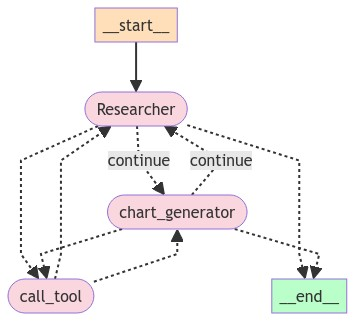

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
import re
import folium
import pandas as pd
import geopandas as gpd

In [21]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Create a list of popular destinations in Hokkaido for sightseeing and food."
                "then generate a pandas dataframe with Name, Latitude, Longitude, and Type columns."
                "Plot the graph using Folium.Map and display it."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3KFSKAXggRBdfhFVplpuVGFA', 'function': {'arguments': '{"query": "popular sightseeing destinations in Hokkaido"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_tUTy4brh5oSMIq2AgKobyOSs', 'function': {'arguments': '{"query": "popular food destinations in Hokkaido"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 231, 'total_tokens': 295}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_f4e629d0a5', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-abb00053-0ee9-4b72-b40a-982fd8b842bc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'popular sightseeing destinations in Hokkaido'}, 'id': 'call_3KFSKAXggRBdfhFVplpuVGFA'}, {'name': 'tavily_search_results_json', 'args': {'query': 'popular food destinations in Hokkaido'}, 'id'